# Spatio-temporal clustering

In [1]:
# le classique imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas
import geoplot
from shapely.geometry import Polygon, Point
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import geoplot.crs as gcrs
import matplotlib as mpl
import random
from tqdm import tqdm
from sklearn.metrics import silhouette_score

pd.set_option('mode.chained_assignment', None)

import sys

path_to_functions = 'C:/Users/Zaca/Documents/GitHub/useful-functions/'
sys.path.append(path_to_functions)

from plotting import default_plot, truncate_colormap

path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

## matplotlib params

In [2]:
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 13
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5   

# Defining functions

In [121]:
# plots a map of all the precincts in NY and only colors in red the one we have selected
def precinct_selected(precinct, basemap, save=False):  
    basemap['selected'] = np.where(basemap.precinct == precinct, 1, 0)   
    ax = geoplot.choropleth(basemap, hue='selected', figsize=(8, 8), lw= 1, edgecolor='k', alpha=1, cmap=new_cmap, projection=gcrs.AlbersEqualArea())
    ax.set_title(str(precinct))
    
    if save:
        plt.savefig('figures/precinct_selected.png', dpi=300)
        
# scales features, runs K-means clusterin algorithm, 
# re-orders labels so cluster 0 is always the largest, calculates silhouttescore
# returns labels
def make_clusters(data, n):
    data = data[['latitude', 'longitude', 'time']]
    data['time'] = data['time']
    
    # scale features
    stdscaler = StandardScaler()
    features = stdscaler.fit_transform(data)
    cluster = KMeans(n)
    model = cluster.fit(features)
    
    # re-label so that cluster 0 is always the largest and so on.
    data['labels'] = model.labels_
    re_labeling = data.labels.value_counts().reset_index()['index']
    data['new_labels'] = data['labels'].replace(list(re_labeling.values), list(re_labeling.index))
    
    print('Cluster sizes:')
    print(data.new_labels.value_counts())
    
    preds = cluster.fit_predict(features)
    score = silhouette_score(features, preds, metric='euclidean')
    print('Silhouette Score:', score)
    
    return data.new_labels.values

# for a single precinct it shows the training data crimes color-coded after clustering
def view_clusters(basemap, labeled_data, save=False):
    
    # view raw training data
    ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], color='k', alpha=.75, s=100)
    
    if save:
        plt.savefig('figures/precinct_zoom_black.png', dpi=300)        
    
    # view clustered data
    ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], color=cluster_colors[i], alpha=.75, s=100)

    if save:
        plt.savefig('figures/precinct_zoom_clustered.png', dpi=300)

# define geographical limits for a precinct, create a grid and fit a gaussian KDE.
# return the XY coordinates for the points in the KDE.
def make_contour(longitude, latitude, precinct_polygon, colors, levels):
    
    x = longitude
    y = latitude
    
    # check bounds
    xmin = precinct_polygon.bounds['minx'].values - 0.0025
    xmax = precinct_polygon.bounds['maxx'].values + 0.0025
    ymin = precinct_polygon.bounds['miny'].values - 0.0025
    ymax = precinct_polygon.bounds['maxy'].values + 0.0025
    
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cset = plt.contour(xx, yy, f, colors=colors, levels=levels, linewidths=1.5)
    
    return cset

# from the contours returned in make_contours this function selects the level n we are interested in.
# just remember that its backwards
# the outermost level is 0
def get_level(contour, n):
    
    x = []
    y = []
    for j in range(len(contour.allsegs)):
        for ii, seg in enumerate(contour.allsegs[j]):
            x += [seg[:,0]]
            y += [seg[:,1]]
    
    return list(zip(x[n], y[n])) 

# grabs the contours for each cluster, selects the level we want and plots the results
def get_view_contours(basemap, labeled_data, precinct, levels, plot=False, save=False):
    
    fig, ax = plt.subplots()
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    
    # make contours for each cluster
    contours = []
    for i in range(len(labeled_data.labels.unique())):
        ctr = make_contour(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], basemap[basemap.precinct == labeled_data.precinct.values[0]]['geometry'], colors=cluster_colors[i], levels=levels)
        contours += [ctr]

    levels = [get_level(x, 0) for x in contours]

    if plot:
        ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)
        for i in range(len(labeled_data.labels.unique())):
            # plot contour edges
            ax.plot([x[0] for x in levels[i]], [x[1] for x in levels[i]], color=cluster_colors[i], lw=5)
            # fill the area
            ax.fill_between([x[0] for x in levels[i]], [x[1] for x in levels[i]], facecolor=cluster_colors[i], alpha=.3)
    
        if save:
            plt.savefig('figures/precinct_zoom_clustered_kde_no_scatter.png', dpi=300)
    return levels


# plots the temporal distribution of each cluster and calculates a patrolling schedule 
# based on the mode of the distribution.
def temporal_distribution(labeled_data, plot=False, save=False):  
    
    min_time = []
    max_time = []
    
    for i in range(len(labeled_data.labels.unique())):
    
        min_calc = stats.mode(labeled_data[labeled_data.labels == i].time)[0][0] - 4
        max_calc = stats.mode(labeled_data[labeled_data.labels == i].time)[0][0] + 4
        
        if min_calc < 0:
            min_calc = 24 + min_calc
        
        if max_calc > 24:
            max_calc = max_calc - 24
            
        min_time += [min_calc]
        max_time += [max_calc]        
        
        print('Cluster ' + str(i+1) + ' schedule:', min_calc, max_calc)
        
    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        ax = default_plot(ax, ['left', 'bottom'])
        plt.xlabel('Time of Day')
        plt.ylabel('Density')
        plt.xlim(0, 24)
        
        for i in range(len(labeled_data.labels.unique())):
            sns.kdeplot(labeled_data[labeled_data.labels == i].time, bw=1.25, color=cluster_colors[i], label=str(i+1), lw=3)
        
        plt.legend(frameon=False, bbox_to_anchor=(1, 1.1), title='Cluster ID') 
        plt.tight_layout()
        
        if save:
            plt.savefig('figures/precinct_cluster_times.png', dpi=300)
            
        # make schedule plot
        fig, ax = plt.subplots(figsize=(5, 2.5))
        ax = default_plot(ax, ['left', 'bottom'])
        plt.xlim(0, 24)
        ax.spines["left"].set_visible(False)
        plt.yticks([1.4, 2.4, 3.4, 4.4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
        plt.xticks(np.arange(0, 27, 3))
        plt.xlabel('Time (h)')
        ax.tick_params(axis='y',length=0)

        for i in range(len(min_time)):
            
            if max_time[i] - min_time[i] < 0:
                plt.fill_between(range(min_time[i], 25), i+1, i+1.8, color=cluster_colors[i])
                plt.fill_between(range(0, max_time[i] + 1), i+1, i+1.8, color=cluster_colors[i])
            plt.fill_between(range(min_time[i], max_time[i] + 1), i+1, i+1.8, color=cluster_colors[i])
            plt.tight_layout()
        
        if save:
            plt.savefig('figures/precinct_cluster_schedule.png', dpi=300)
        
    return list(zip(min_time, max_time))

# this function takes in test data, cluster regions and time windows and returns a score if the
# test points landed within the area and the schedule
def scoring(test_data, contours, time_windows):
    
    # from testing selection, creates shapely points from the coordinate data 
    # and grabs the time of the the crime took place.
    test_points = [Point(x, y) for x, y in list(zip(test_data.longitude, test_data.latitude))]
    test_times = list(test_data.time.values)

    zones = [Polygon(x) for x in contours]
    start_time = [x[0] for x in time_windows]
    end_time = [x[1] for x in time_windows]

    landed = 0
    
    # for each cluster
    for c in range(n_clusters):
        # for each test crime
        for t in range(len(test_points)):
            # if the point is within the cluster and the schedule
            if (test_points[t].within(zones[c])) and (start_time[c] <= test_times[t] <= end_time[c]):
                landed += 1

    if len(test_points) > 0:         
        score = landed/len(test_points)
        if score > 1:
            score = 1
    else:
        score = -1
        
    return landed, len(test_points)

# generating random points within a spec precinct geographical limits
def random_points_within(poly, num_points):
  
    # get exterior limits of the polygon
    min_x, min_y, max_x, max_y = poly.bounds

    points = []
    
    # loop until n points is reached
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        
        # if point inside polygon
        if (random_point.within(poly)):
            points.append(random_point)

    return points

# generating random crimes at random times
def random_clusters(basemap, precinct, size):
    rps = random_points_within(basemap[basemap.precinct == precinct]['geometry'].unary_union, size)
    longs = [p.x for p in rps]
    lats = [p.y for p in rps]
    times = np.random.randint(0, 24, size)
    training = pd.DataFrame({'latitude':lats, 'longitude':longs, 'time':times, 'precinct':[precinct]*size})
    return training

# Choosing colors

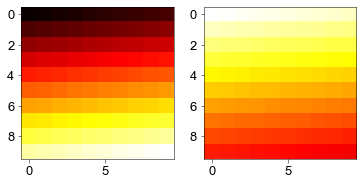

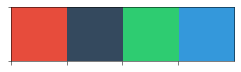

In [5]:
# select the colors to use for cluster labels.
cmap = plt.get_cmap('hot')
new_cmap = truncate_colormap(cmap, 0.35, 1, reverse=True)

cluster_colors = ["#e74c3c", "#34495e", "#2ecc71", "#3498db"]
sns.palplot(sns.color_palette(cluster_colors));

# Preparing base maps

In [6]:
# open shapefile
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['pct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

# Read pre-processed data

In [7]:
# open data
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

# transform to datetime
crime['date'] = pd.to_datetime(crime['date'])

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Select crime type
- Crimes selected: street robbery and home burglary.

In [9]:
ds_burglary = crime[(crime.description == 'BURGLARY') & (crime.premises.str.contains('RESID'))]
ds_robbery = crime[(crime.description == 'ROBBERY') & (crime.premises.str.contains('STREET'))]

# look at number of crime per precinct for exploration
highest_ = ds_burglary.groupby('precinct').agg(count=('date', 'count')).sort_values(by='count', ascending=False)

# Algorithm demonstration
- Here I will create plots and demonstrate how the algorithm works for a single prediction on a single precinct.

## 1. Select parameters

In [157]:
# select the parameters of the algorithm
precinct = 61
training_period = ['2015-01-01', '2017-01-01']
testing_period = ['2017-01-01', '2017-03-01']
n_clusters = 4
n_levels = 4

# select data by crime
ds = ds_burglary

## 2. Separate training and test

In [95]:
# here we separate training and testing data
training = ds[(ds.date > training_period[0]) & (ds.date < training_period[1]) & (ds.precinct == precinct)]
test = ds[(ds.date > testing_period[0]) & (ds.date < testing_period[1]) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)

## 3. K-means clustering

In [102]:
# run clustering function and add labels to the training dataset
#training['labels'] = make_clusters(training, n_clusters)

Cluster sizes:
0    108
1    102
2     94
3     83
Name: new_labels, dtype: int64
Silhouette Score: 0.2744054459428624


## 4. Show selected precinct

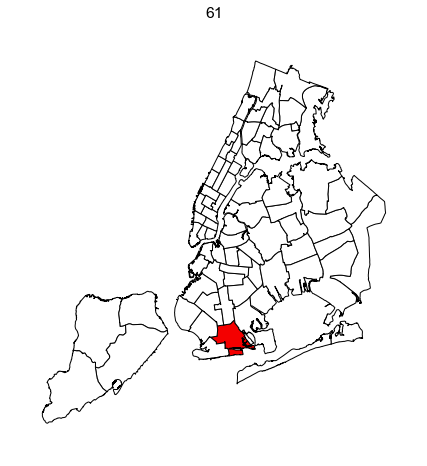

In [112]:
# showing selected precinct
precinct_selected(precinct, clean_map, save=False)

## 5. View raw data and clustering results

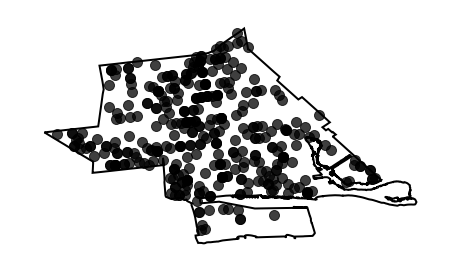

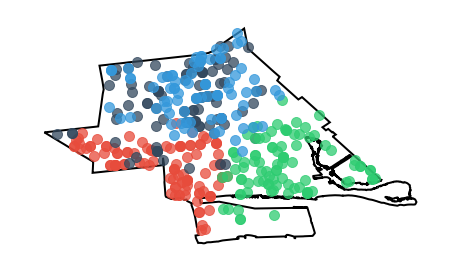

In [113]:
# view clusters identified by training
view_clusters(clean_map, training, save=False)

## 6. Fitting a gaussian KDE and extracting contours

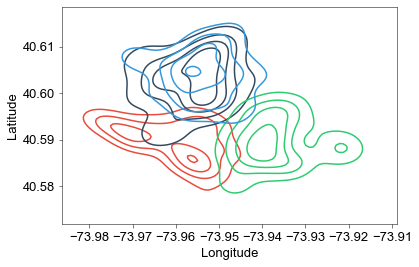

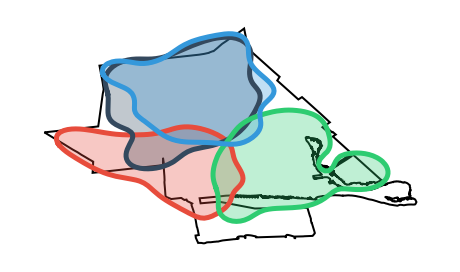

In [114]:
contours = get_view_contours(clean_map, training, precinct, n_levels, plot=True, save=False)

## 7. Getting temporal distribution and extracting schedule

Cluster 1 schedule: 6 14
Cluster 2 schedule: 20 4
Cluster 3 schedule: 3 11
Cluster 4 schedule: 12 20


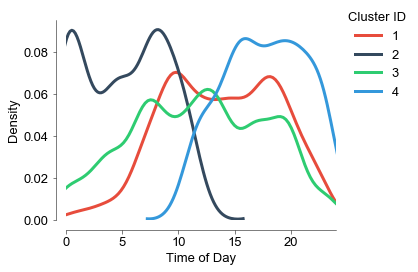

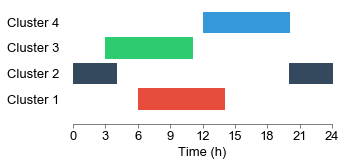

In [115]:
time_windows = temporal_distribution(training, plot=True, save=False)

## 8. Scoring with test data

In [159]:
scoring(test, contours, time_windows)

(18, 30)

# Running the algorithm on two years prediction and top 5 precincts

In [131]:
# defining all the training and testing periods.
training_start = ['2015-01-01', 
                  '2015-02-01',
                  '2015-03-01',
                  '2015-04-01',
                  '2015-05-01',
                  '2015-06-01', 
                  '2015-07-01',
                  '2015-08-01',
                  '2015-09-01', 
                  '2015-10-01',
                  '2015-11-01',
                  '2015-12-01',
                  '2016-01-01',
                  '2016-02-01',
                  '2016-03-01',
                  '2016-04-01',
                  '2016-05-01',
                  '2016-06-01',
                  '2016-07-01',
                  '2016-08-01',
                  '2016-09-01',
                  '2016-10-01',
                  '2016-11-01',
                  '2016-12-01']

training_finis = ['2017-01-01', 
                  '2017-02-01',
                  '2017-03-01',
                  '2017-04-01',
                  '2017-05-01',
                  '2017-06-01', 
                  '2017-07-01',
                  '2017-08-01',
                  '2017-09-01', 
                  '2017-10-01',
                  '2017-11-01',
                  '2017-12-01',
                  '2018-01-01',
                  '2018-02-01',
                  '2018-03-01',
                  '2018-04-01',
                  '2018-05-01',
                  '2018-06-01',
                  '2018-07-01',
                  '2018-08-01',
                  '2018-09-01',
                  '2018-10-01',
                  '2018-11-01',
                  '2018-12-01']

testing_start_ = ['2017-01-01', 
                  '2017-02-01',
                  '2017-03-01',
                  '2017-04-01',
                  '2017-05-01',
                  '2017-06-01', 
                  '2017-07-01',
                  '2017-08-01',
                  '2017-09-01', 
                  '2017-10-01',
                  '2017-11-01',
                  '2017-12-01',
                  '2018-01-01',
                  '2018-02-01',
                  '2018-03-01',
                  '2018-04-01',
                  '2018-05-01',
                  '2018-06-01',
                  '2018-07-01',
                  '2018-08-01',
                  '2018-09-01',
                  '2018-10-01',
                  '2018-11-01',
                  '2018-12-01']

testing_finis_ = ['2017-02-01', 
                  '2017-03-01',
                  '2017-04-01',
                  '2017-05-01',
                  '2017-06-01',
                  '2017-07-01', 
                  '2017-08-01',
                  '2017-09-01',
                  '2017-10-01', 
                  '2017-11-01',
                  '2017-12-01',
                  '2018-01-01',
                  '2018-02-01',
                  '2018-03-01',
                  '2018-04-01',
                  '2018-05-01',
                  '2018-06-01',
                  '2018-07-01',
                  '2018-08-01',
                  '2018-09-01',
                  '2018-10-01',
                  '2018-11-01',
                  '2018-12-01',
                  '2018-12-31']

# Define main functions

In [134]:
def main(ds, training_period, precinct, n_clusters, testing_period, n_levels=4):
    
    subselection = ds[(ds.date > training_period[0]) & (ds.date < training_period[1]) & (ds.precinct == precinct)]
    subselection['labels'] = make_clusters(subselection, n_clusters)
    test_selection = ds[(ds.date > testing_period[0]) & (ds.date < testing_period[1]) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)   
    time_windows = temporal_distribution(subselection)
    contours = get_view_contours(clean_map, subselection, precinct=precinct, levels=n_levels)
    return scoring(test_selection, contours, time_windows)


def random_main(ds, training_period, precinct, n_clusters, testing_period, n_levels=44):
    test_selection = ds[(ds.date > testing_period[0]) & (ds.date < testing_period[1]) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)
    subselection = ds[(ds.date > training_period[0]) & (ds.date < training_period[1]) & (ds.precinct == precinct)]
    simulated = random_clusters(clean_map, precinct, size=subselection.shape[0])
    simulated['labels'] = make_clusters(simulated, n_clusters)
    time_windows = temporal_distribution(simulated)
    contours = get_view_contours(clean_map, simulated, precinct=precinct, levels=n_levels)
    return scoring(test_selection, contours, time_windows)
    

In [169]:
n_clusters = 4
n_levels = 4
precincts = list(highest_.index[:5])

In [170]:
def final_testing(ds, precincts, training_start, training_finis, testing_start, testing_finis):
        
    n_clusters = 4
    n_levels = 4
    
    output = pd.DataFrame()
    
    for i in tqdm(range(len(testing_start))):
        
        training_period = [training_start[i], training_finis[i]]
        testing_period = [testing_start[i], testing_finis[i]]
        scores = []
        random_scores = []
                
        for j in tqdm(range(len(precincts))):
            scores += [main(ds=ds, training_period=training_period, precinct=precincts[j], n_clusters=n_clusters, testing_period=testing_period, n_levels=n_levels)]
            random_scores += [random_main(ds=ds, training_period=training_period, precinct=precincts[j], n_clusters=n_clusters, testing_period=testing_period, n_levels=n_levels)]
        
        predicted = [x[0] for x in scores]
        observed = [x[1] for x in scores]
        random_predicted = [x[1] for x in random_scores]
        
        data = pd.DataFrame({'precinct': precincts, 
                'prediction': predicted, 
                'observed': observed, 
                'random_prediction':random_predicted,
                'date':testing_start[i]})
        
        output = pd.concat([output, data], ignore_index= True)
                  
    return output
    

In [ ]:
sixty_one = final_testing(ds, precincts, training_start, training_finis, testing_start_, testing_finis_)

  0%|          | 0/5 [00:00<?, ?it/s]

Cluster sizes:
0    173
1    161
2    146
3    141
Name: new_labels, dtype: int64
Silhouette Score: 0.25524449053417625
Cluster 1 schedule: 4 12
Cluster 2 schedule: 14 22
Cluster 3 schedule: 8 16
Cluster 4 schedule: 6 14
Cluster sizes:
0    186
1    159
2    149
3    127
Name: new_labels, dtype: int64
Silhouette Score: 0.27386483758305635
Cluster 1 schedule: 23 7
Cluster 2 schedule: 12 20
Cluster 3 schedule: 15 23
Cluster 4 schedule: 19 3



 20%|██        | 1/5 [00:01<00:04,  1.08s/it]

Cluster sizes:
0    274
1    148
2    127
3     81
Name: new_labels, dtype: int64
Silhouette Score: 0.29748377362471773
Cluster 1 schedule: 5 13
Cluster 2 schedule: 10 18
Cluster 3 schedule: 13 21
Cluster 4 schedule: 5 13
Cluster sizes:
0    194
1    185
2    139
3    112
Name: new_labels, dtype: int64
Silhouette Score: 0.3351129791424196
Cluster 1 schedule: 10 18
Cluster 2 schedule: 3 11
Cluster 3 schedule: 23 7
Cluster 4 schedule: 9 17



 40%|████      | 2/5 [00:01<00:03,  1.03s/it]

Cluster sizes:
0    187
1    143
2    141
3     91
Name: new_labels, dtype: int64
Silhouette Score: 0.30983233235027086
Cluster 1 schedule: 14 22
Cluster 2 schedule: 3 11
Cluster 3 schedule: 8 16
Cluster 4 schedule: 8 16
Cluster sizes:
0    177
1    149
2    140
3     96
Name: new_labels, dtype: int64
Silhouette Score: 0.32188670768769023
Cluster 1 schedule: 21 5
Cluster 2 schedule: 18 2
Cluster 3 schedule: 15 23
Cluster 4 schedule: 23 7



 60%|██████    | 3/5 [00:03<00:02,  1.18s/it]

Cluster sizes:
0    142
1    134
2    126
3     52
Name: new_labels, dtype: int64
Silhouette Score: 0.29630706722673095
Cluster 1 schedule: 14 22
Cluster 2 schedule: 4 12
Cluster 3 schedule: 6 14
Cluster 4 schedule: 8 16
Cluster sizes:
0    126
1    119
2    107
3    102
Name: new_labels, dtype: int64
Silhouette Score: 0.30221175122077415
Cluster 1 schedule: 11 19
Cluster 2 schedule: 6 14
Cluster 3 schedule: 10 18
Cluster 4 schedule: 20 4



 80%|████████  | 4/5 [00:05<00:01,  1.42s/it]

Cluster sizes:
0    132
1    121
2     97
3     69
Name: new_labels, dtype: int64
Silhouette Score: 0.34840038905526094
Cluster 1 schedule: 11 19
Cluster 2 schedule: 3 11
Cluster 3 schedule: 3 11
Cluster 4 schedule: 16 24
Cluster sizes:
0    128
1    103
2    102
3     86
Name: new_labels, dtype: int64
Silhouette Score: 0.3573532115563503
Cluster 1 schedule: 23 7
Cluster 2 schedule: 17 1
Cluster 3 schedule: 9 17
Cluster 4 schedule: 22 6



  0%|          | 0/5 [00:00<?, ?it/s]

Cluster sizes:
0    175
1    162
2    145
3    143
Name: new_labels, dtype: int64
Silhouette Score: 0.25589163647773977
Cluster 1 schedule: 4 12
Cluster 2 schedule: 14 22
Cluster 3 schedule: 8 16
Cluster 4 schedule: 4 12
Cluster sizes:
0    180
1    154
2    153
3    138
Name: new_labels, dtype: int64
Silhouette Score: 0.2813792049976245
Cluster 1 schedule: 14 22
Cluster 2 schedule: 21 5
Cluster 3 schedule: 14 22
Cluster 4 schedule: 1 9



 20%|██        | 1/5 [00:01<00:05,  1.40s/it]

Cluster sizes:
0    263
1    151
2    121
3     88
Name: new_labels, dtype: int64
Silhouette Score: 0.30152432998031375
Cluster 1 schedule: 5 13
Cluster 2 schedule: 10 18
Cluster 3 schedule: 13 21
Cluster 4 schedule: 5 13
Cluster sizes:
0    182
1    164
2    154
3    123
Name: new_labels, dtype: int64
Silhouette Score: 0.3061132050594593
Cluster 1 schedule: 12 20
Cluster 2 schedule: 3 11
Cluster 3 schedule: 6 14
Cluster 4 schedule: 11 19



 40%|████      | 2/5 [00:02<00:03,  1.29s/it]

Cluster sizes:
0    168
1    153
2    152
3     85
Name: new_labels, dtype: int64
Silhouette Score: 0.29039972681874204
Cluster 1 schedule: 3 11
Cluster 2 schedule: 14 22
Cluster 3 schedule: 8 16
Cluster 4 schedule: 8 16
Cluster sizes:
0    175
1    166
2    138
3     79
Name: new_labels, dtype: int64
Silhouette Score: 0.31132981684702565
Cluster 1 schedule: 14 22
Cluster 2 schedule: 20 4
Cluster 3 schedule: 0 8
Cluster 4 schedule: 11 19



 60%|██████    | 3/5 [00:03<00:02,  1.33s/it]

Cluster sizes:
0    141
1    134
2    128
3     50
Name: new_labels, dtype: int64
Silhouette Score: 0.29760421417012417
Cluster 1 schedule: 14 22
Cluster 2 schedule: 4 12
Cluster 3 schedule: 6 14
Cluster 4 schedule: 8 16


In [163]:
sixty_one

,precinct,prediction,observed,random_prediction,date
0,61,10,13,13,2017-01-01
1,61,9,16,16,2017-02-01
2,61,5,14,14,2017-03-01
3,61,5,6,6,2017-04-01
4,61,7,11,11,2017-05-01
5,61,2,7,7,2017-06-01
6,61,4,10,10,2017-07-01
7,61,4,13,13,2017-08-01
8,61,5,14,14,2017-09-01
9,61,8,13,13,2017-10-01


In [ ]:
#burglary = final_testing(ds, precincts, training_start, training_finis, testing_start_, testing_finis_)

In [ ]:
#burglary['perc'] = burglary['prediction'] / burglary['observed'] * 100
#burglary['random_perc'] = burglary['random_prediction'] / burglary['observed'] * 100

In [ ]:
#burglary['perc'] = np.where(burglary.perc > 100, 100, burglary.perc)
#burglary['random_perc'] = np.where(burglary.random_perc > 100, 100, burglary.random_perc)

In [ ]:
#plt.hist(burglary.perc)
#plt.hist(burglary.random_perc)

In [ ]:
#burglary.to_csv(path + 'burglary.csv')

In [ ]:
#robbery = final_testing(ds, precincts, training_start, training_finis, testing_start_, testing_finis_)

In [ ]:
#robbery.to_csv(path + 'robbery.csv')

# Creating figures for a video

In [ ]:
labeled_data = training.copy()
basemap = clean_map.copy()
levels = contours
hits = 0
total = 0

cluster_hours = [list(range(x, x+8)) for x in start_time]
cluster_hours_fixed = []
for i in cluster_hours:
    cluster_hours_fixed += [[x - 24 if x > 23 else x for x in i ]]
cluster_hours_fixed

for i in range(24):
    
    ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)
    active_clusters = []
    for j in range(n_clusters):
        if i in cluster_hours_fixed[j]:
            ax.plot([x[0] for x in levels[j]], [x[1] for x in levels[j]], color=cluster_colors[j], lw=5)
            ax.fill_between([x[0] for x in levels[j]], [x[1] for x in levels[j]], facecolor=cluster_colors[j], alpha=0.3)
            active_clusters += [j]
            
    for k in range(len(test_points)):
        if test_times[k] == i:
            total += 1
            ax.scatter(test_points[k].x, test_points[k].y, s=300, c='k', edgecolor='k')
            for x in active_clusters:
                if test_points[k].within(zones[x]):
                    ax.scatter(test_points[k].x, test_points[k].y, s=300, c='r', edgecolor='k')
                    hits += 1
                    
    bbox_props = dict(boxstyle='round,pad=0.25', fc='white', ec='black')
    plt.text(0.7, 0.9, s='Time: ' + str(i) + ':00', transform=ax.transAxes, fontsize=20)
    plt.text(0.7, 0.8, s='Hits: ' + str(hits), transform=ax.transAxes, fontsize=20)
    plt.text(0.7, .7, s='Total: ' + str(total), transform=ax.transAxes, fontsize=20)
    plt.tight_layout()
    #plt.savefig('figures/gif' + str(i) + '.png', dpi=300)